# Ames Housing Data EDA

This project aims to predict housing prices in Ames, Iowa based on the famous Ames Iowa Housing Dataset from the Ames City Assessor's Office, made available by Dean De Cock of Truman University in 2011. Professor De Cock's original paper can be found [here.](http://jse.amstat.org/v19n3/decock.pdf)

Presentation Slides for this project can be found [here.](https://www.beautiful.ai/player/-N4J5UYshyuRtwl5G4I7)

This notebook includes python code for data extraction, cleaning and transformation. Model Fitting and Analysis code can be found in the Ames_Models notebook.

# Sections and steps

- <a href="#IMP">Reading in Data</a><br>
    
- <a href="#EDA">Exploratory Data Analysis</a><br>
  
- <a href="#FEN">Feature Engineering</a><br>
    - Dropped Features
        - columns with no meaningful difference between categories
        - low correlation
        - Multicollinearity
    - Feature Engineering
        - Land and Exterior
        - House Quality
        - Location
        - Garage
        - Basement
        - Sale Info
- <a href="#PRE">Preparing Data for Models</a><br>
    - Linear Models
        -dummify categorical variables
    - Non Linear Models
        -label encode categorical variables
    - All Models
        -split train and validate datasets
        -standardize the numerical variables
- <a href="#EXP">Exporting Cleaned Datasets</a><br>

<p><a name="IMP"></a></p>

## Importing Packages, Reading in Data

In [1]:
import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.formula.api import ols
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 12})

### Importing helper module

In [2]:
#importing helper functions from helper module
from helper_module import * #look_cat, look_num

### Reading in train data

In [3]:
train = pd.read_csv('./data/raw/train.csv')
train.head()
#train.drop(['Unnamed: 0'], axis=1, inplace=True)
print(f"Read in Ames Housing Train Data - Shape: {train.shape}")

Read in Ames Housing Train Data - Shape: (1460, 81)


### Reading in test data

In [4]:
test = pd.read_csv('./data/raw/test.csv')
test.head()
#test.drop(['Unnamed: 0'], axis=1, inplace=True)
print(f"Read in Ames Housing Test Data - Shape: {test.shape}")

Read in Ames Housing Test Data - Shape: (1459, 80)


<p><a name="EDA"></a></p>

## Exploratory Data Analysis

### Train Dataset Overview

In [5]:
print('The raw number of features is ', train.shape[1])
print('The raw number of observations is ', train.shape[0])
print('The datattypes are:', train.dtypes.unique())

The raw number of features is  81
The raw number of observations is  1460
The datattypes are: [dtype('int64') dtype('O') dtype('float64')]


Looking at the data description, there are several ordinal variables that are coded as numeric. These variables correspond to the following column names:
- MSSubClass
- OverallQual
- OverallCond
- MoSold
- YrSold

Let's make sure these are coded as categorical.

In [6]:
#checking to see how these variables are coded
L = ['MSSubClass', 'OverallQual', 'OverallCond', 'MoSold', 'YrSold', 'GarageYrBlt']
for item in L:
    print(train[item].dtype)

int64
int64
int64
int64
int64


In [7]:
#changing the dtype of these variables to strings
for item in L:
    train[item] = train[item].astype(str)

In [8]:
#selecting just categorical variables in the dataframe and creating a list
cat_var = train.select_dtypes('O').columns.tolist()

#selecting just continuous variables in the dataframe and creating a list
num_var = train.select_dtypes('number').columns.tolist()
num_var.remove('Id')

#creating a list of all variables as an EDA checklist
all_var = train.columns.tolist()
all_var.remove('Id')

print('The number of categorical features is' , len(cat_var))
print('The number of numerical features is', len(num_var))

#Sanity check here
print('The combined numerical and categorical features are', len(cat_var) + len(num_var))
print('Number of Variables left to examine : ', len(all_var))

The number of categorical features is 48
The number of numerical features is 32
The combined numerical and categorical features are 80
Number of Variables left to examine :  80


### Dependent Variable Analysis - Sale Price

In [9]:
#descriptive summary of Sale Price
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

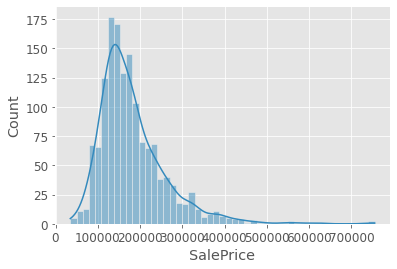

<Figure size 432x288 with 0 Axes>

In [10]:
#plotting a histogram using seaborn
#histogram
sns.histplot(train['SalePrice'], kde = True);
fig = plt.figure()
#TODO - clean up this diagram

Noticing that the dependent variable looks right skewed (aka not normally distributed)

In [11]:
#checking skewness and kurtosis
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


To ensure that the residuals of a linear model taken will be normal, we will take the log of the Sale Price instead of the Sale Price.

In [12]:
#adding a column for log sale price
train['log_SalePrice'] = np.log(train['SalePrice'])

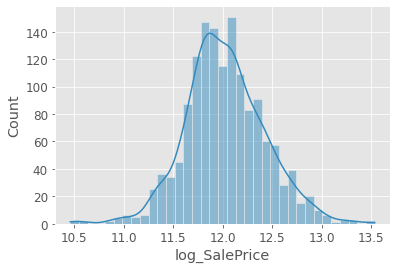

In [13]:
#plotting a histogram using seaborn
#histogram
sns.histplot(train['log_SalePrice'], kde = True);
#TODO - clean up this diagram

In [14]:
#checking skewness and kurtosis
print("Skewness: %f" % train['log_SalePrice'].skew())
print("Kurtosis: %f" % train['log_SalePrice'].kurt())

Skewness: 0.121335
Kurtosis: 0.809532


## Independent Variables Analysis

### First Pass Categorical Features
To get a sense of the independent variables in this dataset, we'll use a helper function to iterate through each categorical variable and look at:
- missing data
- anomalies and outliers
- distribution via barplot and boxplot

No changes will be made to data - this will be saved for feature engineering and selection.

In [16]:
view_cat = look_cat(cat_var)

In [111]:
next(view_cat)

StopIteration: 

In [110]:
#looking at value counts for graphs that have low frequencies in some categories
train['SaleCondition'].value_counts()

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64

#### First Pass Categorical Findings :
1. Variables that are candidates for ANOVA and potential condensing
    - MSSubClass
    - MSZoning
    - LotShape
    - LotConfig
    - LandSlope
    - Neighborhood
    - Condition1
    - RoofStyle
    - Exterior1st
    - Exterior2nd
    - BsmtFinType1
    - Electrical
    - Functional
2. Variables that are candidates for binarization
    - Street --> paved or gravel
    - Alley --> NA is No Alley access
    - LandContour --> Lvl and not lvl
    - Heating --> Mostly Gas A and Other
    - RoofMatl --> Standard Shingle or not
    - GarageType --> Mostly Attached and Other
    - GarageQual --> Mostly TA and Other
    - GarageCond --> Mostly TA and Other
    - PavedDrive --> Mostly Paved and Other
    - Fence --> 80% missing, NA is no fence
    - SaleType --> WD and Other
3. Variables that are candidates to be dropped
    - Utilities --> all obs but one have all Pub Utilities
    - Condition2 --> only 15 obs with conditions
    - PoolQC --> missing data for 99.52% of obs
    - MiscFeature --> missing 96% of obs, NA is no misc feature
4. Other
    - Bldg Type --> Twnhs should be TwnhsI
    - Def want to keep OverallQual
    - Keep ExterQual
    - BsmtQual --> NA is no basement, 37 missing values
    - Same for BsmtCond --> Na is no basement
    - BsmtExposure --> 38 missing
    - BsmtFintype 1 and 2 have missing vals -
    - Electrical has 1 missing val
    - Keep Kitchen Qual
    - Fireplace Quality has 690 missing obs --> na is no fireplace
    - Garage Type --> Na is no garage
    - MoSold to potential Season?
        
        

### First Pass Continunous Features
To get a sense of the idependent variables in this dataset, we'll use a helper function to iterate through each categorical variable and look at:
- missing data
- anomalies and outliers
- distribution via histogram and scatterplot

No changes will be made to data - this will be saved for feature engineering and selection.

In [112]:
view_num = look_num(num_var)

SalePrice has 0 missing observations, equal to 0.0%


<AxesSubplot:xlabel='SalePrice', ylabel='Log of Sale Price'>

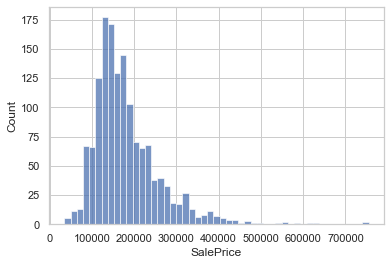

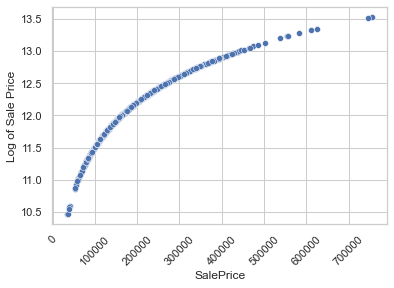

In [144]:
next(view_num)

### Looking into Multicollinearity among Continuous Features

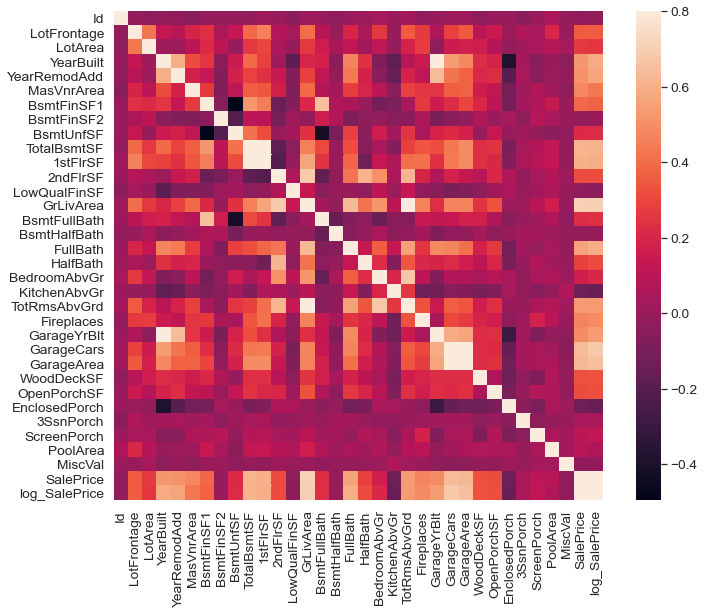

In [263]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

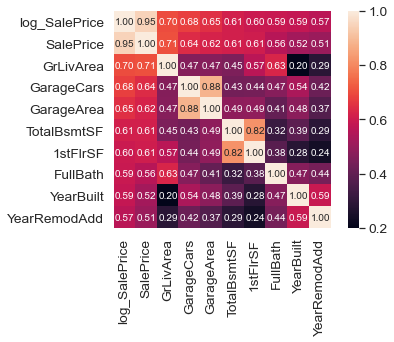

In [264]:
#log_saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'log_SalePrice')['log_SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

#### First Pass Continuous Features Findings:
1. Missingness
    - Lot Frontage : Linear feet of street connected to property
        -Check to see if condos? or high density dwelling?
    - MasVnrArea has 8 missing
2. Outliers
    - LotArea has big outliers
    - BsmtFinSF1 has one potential outlier
    - BedroomAbvGr has one potential outlier of 8
3. Possible feature Engineering
    - Years Since Remodel/Age of Home
    - Number of Bathrooms
    - PoolArea to binary?
4. Possible Drops
    - Garage Area (multicollinearity with GarageCars, but GarageCars has higher correlation with log_SalePrice)
    - One of TotalBsmtSF and 1stFlrSF - Multicollinearity
5. Other
      - Keep GrLivArea

## Second Pass Looking at Independent Variables
It seems like the independent variables in this dataset fall broadly into these 'buckets':
- Location Characterics - neighborhood, lot and land characteristics
- House Quality and Construction- year built, types of materials used and quality
- Basement
- Utilities
- Indoor Areas
- Semi-Indoor Areas - Garage, Porches, Pool, Fence
- Sale Information - month, year, type of sale etc

Since the patterns of missing data also seem to fall into 'buckets', in our in-depth pass, we will look at variables by these buckets.

In [268]:
#Bucketing variables into lists
Location = ['MSSubClass','MSZoning', 'MSZoning','LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2']
HouseQual = ['BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt','YearRemodAdd', 'RoofStyle','RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation']
Basement = ['BsmtQual','BsmtCond','BsmtExposure', 'BsmtFinType1','BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']
Utilities = ['Utilities', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical']
IndoorA = ['1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu']
Garage = ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',]
PorchPlus = ['PavedDrive','WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'log_SalePrice']
SaleInfo = ['MoSold','YrSold','SaleType', 'SaleCondition', 'log_SalePrice']

In [152]:
#initializing an iterator to help bucket variables
#call_var = iter(all_var)
#next(call_var)

In [245]:
#Sanity Check to make sure I got all the variables, minus our dependent variable - looking for 80
bucketlist = [Location, HouseQual, Basement, Utilities, IndoorA, Garage, PorchPlus, SaleInfo]
temp_ = 0
for L in bucketlist:
    temp_ += len(L)
temp_

80

# Garage

In [286]:
df_g = train[Garage]
print(df_g.columns)

#Missing Values
df_g.isna().sum()

Index(['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond'],
      dtype='object')


GarageType      81
GarageYrBlt     81
GarageFinish    81
GarageCars       0
GarageArea       0
GarageQual      81
GarageCond      81
dtype: int64

From Data Description -> Na is No Garage, so we will impute 

## PorchPlus


In [283]:
df_pp = train[PorchPlus]
df_pp.columns

Index(['PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal',
       'log_SalePrice'],
      dtype='object')

In [272]:
#Missing Values
df_sale.isna().sum()

MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
log_SalePrice    0
dtype: int64

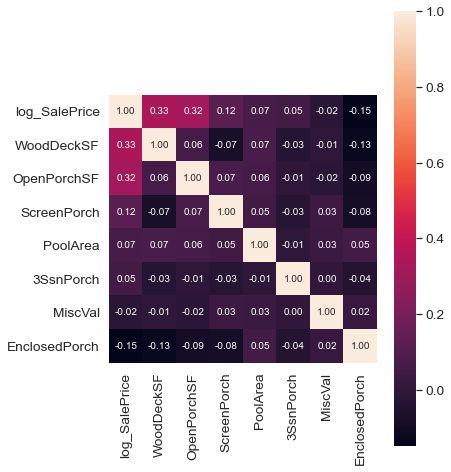

In [282]:
#correlation matrix
corrmat = df_pp.corr()
f, ax = plt.subplots(figsize=(6, 8))

k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'log_SalePrice')['log_SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

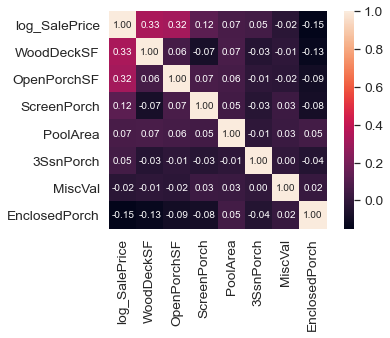

## Sale Info

In [251]:
df_sale = train[SaleInfo]

In [252]:
df_sale.head()

,MoSold,YrSold,SaleType,SaleCondition,log_SalePrice
0,2,2008,WD,Normal,12.247694
1,5,2007,WD,Normal,12.109011
2,9,2008,WD,Normal,12.317167
3,2,2006,WD,Abnorml,11.849398
4,12,2008,WD,Normal,12.429216


In [253]:
#Missing Values
df_sale.isna().sum()

MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
log_SalePrice    0
dtype: int64

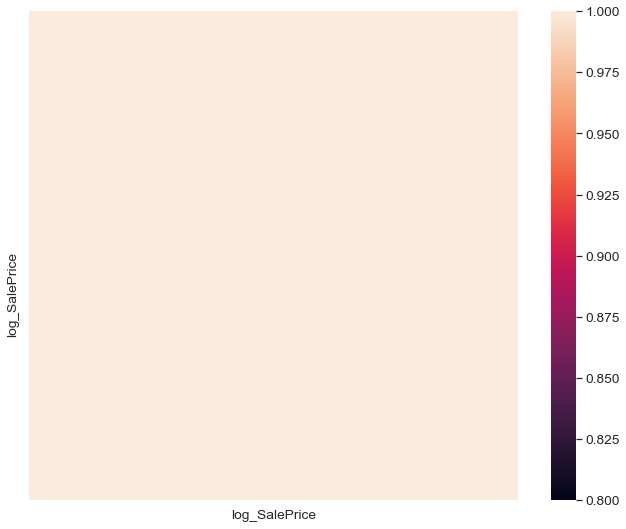

In [258]:
#correlation matrix
corrmat = df_sale.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [257]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [148]:
## Looking into number of missing values
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Number Missing', 'Percent Missing'])
missing_data.head(29)

,Number Missing,Percent Missing
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageQual,81,0.055479


In [150]:
train['PoolQC'].isnull().sum()

1453

### Summary of Data Cleaning

#### Data Imputation
PoolQC --> 1453 NA imputed to 0 for no pool

#### Handling Outliers and Anomalies

#### Categorical Features - box plot, bar plot, ANOVA

#### Quantitative Features - correlation matrix, histogram

### Summary of obs dropped, and vars flagged for feature engineering
- 4 observations dropped - outliers in gr liv area

#### Variables flagged for feature engineering

#### Looking into Multicollinearity

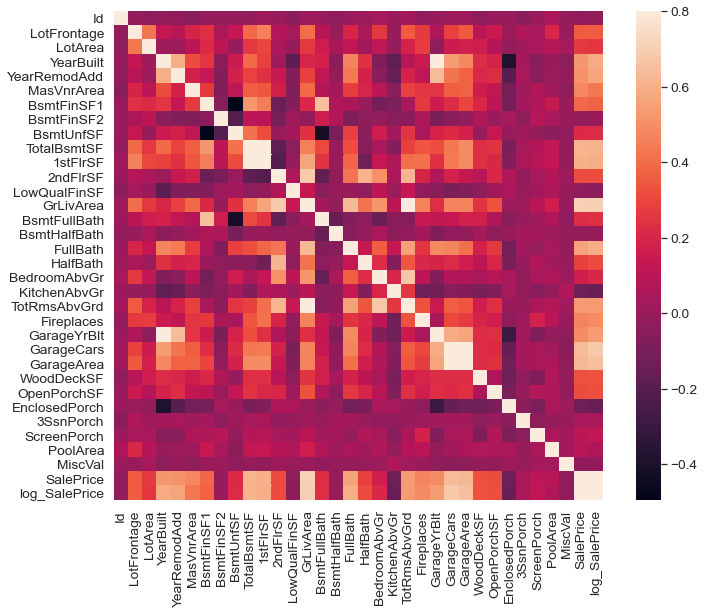

In [259]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

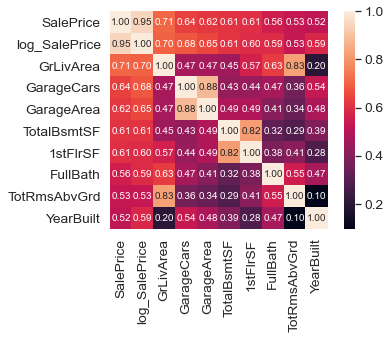

In [262]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

<p><a name="FEN"></a></p>

## Feature Engineering

### Feature Engineering

Previously modified features:-

Sale Price -> Log of Sale Price

#### Land and Exterior

#### House Quality

#### Location

#### Garage

#### Basement

#### Sale Info

### Dropped Features

#### Columns with no meaningful difference between categories

#### Low correlation

#### Multicollinearity

#### Administrative Columns

<p><a name="PRE"></a></p>

## Preprocessing Data for Models

### Linear Models
#### Dummification of Categorical Variables

#### Testing Assumptions for Linear Models

### Non Linear Models
#### Label Encoding of Categorical Variables

### All Models
#### Standardization of numerical variables
#### Split train and validate datasets

<p><a name="EXP"></a></p>

## Exporting Cleaned Datasets

# LE TESTING AREA! DO NOT ENTER

In [ ]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent Missing'])
missing_data.head(25)

In [ ]:
train.isnull().sum().sort_values(ascending=False)

In [ ]:
print(covariance)

In [ ]:
from scipy.stats import pearsonr
corr = pearsonr(train['LotArea'],train['SalePrice'])

In [ ]:
print('Pearsons correlation:', corr[0])

In [ ]:
round(corr[0],3)

In [ ]:
round(corr[1],5)